# Basic machine learning

## Loading preliminary packages

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
# Functionality for computing features
from pyspark.ml import feature
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline

In [3]:
# we will use pandas to display the data nicely
import pandas as pd
datasource = pd.read_csv('diabetes.tab.txt', delimiter='\t')
datasource.columns = ['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu', 'disease_progression']
diabetes_df = spark.createDataFrame(datasource)

Print the first 5 rows of the pandas dataframe

In [4]:
datasource.head(5)

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,disease_progression
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


Print the spark dataframe schema

In [5]:
diabetes_df.printSchema()

root
 |-- age: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- bmi: double (nullable = true)
 |-- map: double (nullable = true)
 |-- tc: long (nullable = true)
 |-- ldl: double (nullable = true)
 |-- hdl: double (nullable = true)
 |-- tch: double (nullable = true)
 |-- ltg: double (nullable = true)
 |-- glu: long (nullable = true)
 |-- disease_progression: long (nullable = true)



Print the first 5 rows of the spark data frame.

In [6]:
diabetes_df.head(5)

[Row(age=59, sex=2, bmi=32.1, map=101.0, tc=157, ldl=93.2, hdl=38.0, tch=4.0, ltg=4.8598, glu=87, disease_progression=151),
 Row(age=48, sex=1, bmi=21.6, map=87.0, tc=183, ldl=103.2, hdl=70.0, tch=3.0, ltg=3.8918, glu=69, disease_progression=75),
 Row(age=72, sex=2, bmi=30.5, map=93.0, tc=156, ldl=93.6, hdl=41.0, tch=4.0, ltg=4.6728, glu=85, disease_progression=141),
 Row(age=24, sex=1, bmi=25.3, map=84.0, tc=198, ldl=131.4, hdl=40.0, tch=5.0, ltg=4.8903, glu=89, disease_progression=206),
 Row(age=50, sex=1, bmi=23.0, map=101.0, tc=192, ldl=125.4, hdl=52.0, tch=4.0, ltg=4.2905, glu=80, disease_progression=135)]

Let's take a look at age and compute several statistics in the population:

In [7]:
diabetes_df.select(fn.count('*'), fn.avg('age'), fn.min('age'), fn.max('age'), fn.stddev('age')).show()

+--------+-----------------+--------+--------+------------------+
|count(1)|         avg(age)|min(age)|max(age)|  stddev_samp(age)|
+--------+-----------------+--------+--------+------------------+
|     442|48.51809954751131|      19|      79|13.109027822041094|
+--------+-----------------+--------+--------+------------------+



There are several functions in `functions` to compute other statistics. For example, we can compute the correlation between two variables:

In [8]:
diabetes_df.select(fn.corr('bmi', 'disease_progression')).show()

+------------------------------+
|corr(bmi, disease_progression)|
+------------------------------+
|            0.5864501344746886|
+------------------------------+



**You can collect any Spark dataframe into a Pandas dataframe by using the method `toPandas()`. However, you have to be very careful because this will collect all the information from the workers and push the data to the driver. If the driver does not have enough memory to hold a big dataset, then Spark might crash. So before running `toPandas()` make sure that the Spark dataframe you are collecting is relatively small**

To start, we can take a look at the distribution of things by using the `describe` method in a Spark dataframe and then collecting it into a Pandas dataframe:

In [9]:
diabetes_df.describe().toPandas()

,summary,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,disease_progression
0,count,442,442,442,442,442,442,442,442,442,442,442
1,mean,48.51809954751131,1.4683257918552035,26.375791855203616,94.64701357466062,189.14027149321268,115.43914027149322,49.78846153846154,4.070248868778281,4.641410859728506,91.26018099547511,152.13348416289594
2,stddev,13.109027822041094,0.49956117043535436,4.418121560615773,13.831283419782999,34.60805167504306,30.413080969276546,12.934202154863327,1.2904498966082776,0.5223905610694908,11.496334739334172,77.09300453299109
3,min,19,1,18.0,62.0,97,41.6,22.0,2.0,3.2581,58,25
4,max,79,2,42.2,133.0,301,242.4,99.0,9.09,6.107,124,346


In our case, we know that we only have 442 observations so we can collect the data easily. However, sometimes your dataset is too big so you might want to *sample* from it.

There is a method called `sample(with_replacement, fraction)` that allows you to do that. `with_replacement` indicates whether you will replace back samples that you already sampled and `fraction` indicates the fraction of rows that you will sample.

For example, a 0.1 sample will give you 10% of 442, which is approximately 44:

In [10]:
diabetes_df.sample(False, 0.1).count()

43

Now, again, the diabetes dataset is not that big, so we can collect all of it into the driver.

Now, we can plot `bmi` vs `disease_progression`:

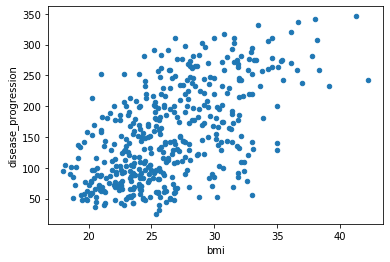

In [11]:
diabetes_df.select('bmi', 'disease_progression').toPandas().plot(x='bmi', y='disease_progression', kind='scatter');

We can also do other kinds of plots, such as histograms:

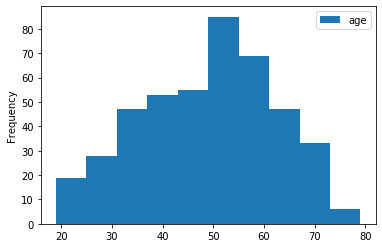

In [12]:
diabetes_df.select('age').toPandas().plot(kind='hist');

## Linear relationship between BMI and disease progression

Linear regression is built on the idea that there is a linear relationship between a set of explanatory variables (or independent variables) and a dependent variable (or taget variable).

$$Y = f(X) = b_0 + b_1 x_1 + b_2 x_2 + \dots + b_m x_m$$

using maximum likelihood estimation we estimate such a model by finding the values of \\(b_0, \dots, b_m\\) that minimize the mean square error:

$$\hat{b} = \arg \min_b \sum (Y_i - f(X_i))^2$$

With Spark, we can find such relationship with a `LinearRegression` estimator.

First, `LinearRegression` receives as input a vector of features. The `bmi` column, however, is a scalar so we need to transform it into a vector of size one.

We will do this by using an estimator that takes a set of columns and produces a single column as a vector, which combines all the input columns. This estimator is called `VectorAssembler` and it is defined inside `pyspark.ml.feature.VectorAssembler`

In [13]:
diabetes_df

DataFrame[age: bigint, sex: bigint, bmi: double, map: double, tc: bigint, ldl: double, hdl: double, tch: double, ltg: double, glu: bigint, disease_progression: bigint]

In [14]:
va = feature.VectorAssembler(inputCols=['bmi'], outputCol='features')

In [15]:
lr = regression.LinearRegression(featuresCol='features', labelCol='disease_progression')

In [16]:
pipe = Pipeline(stages=[va, lr])

In [17]:
pipe_model = pipe.fit(diabetes_df)

# Prediction

In [18]:
pipe_model.transform(diabetes_df)

DataFrame[age: bigint, sex: bigint, bmi: double, map: double, tc: bigint, ldl: double, hdl: double, tch: double, ltg: double, glu: bigint, disease_progression: bigint, features: vector, prediction: double]

In [19]:
pipe_model.transform(diabetes_df).show(5)

+---+---+----+-----+---+-----+----+---+------+---+-------------------+--------+------------------+
|age|sex| bmi|  map| tc|  ldl| hdl|tch|   ltg|glu|disease_progression|features|        prediction|
+---+---+----+-----+---+-----+----+---+------+---+-------------------+--------+------------------+
| 59|  2|32.1|101.0|157| 93.2|38.0|4.0|4.8598| 87|                151|  [32.1]|210.71003806366969|
| 48|  1|21.6| 87.0|183|103.2|70.0|3.0|3.8918| 69|                 75|  [21.6]|103.26219542761143|
| 72|  2|30.5| 93.0|156| 93.6|41.0|4.0|4.6728| 85|                141|  [30.5]|194.33703347150845|
| 24|  1|25.3| 84.0|198|131.4|40.0|5.0|4.8903| 89|                206|  [25.3]|141.12476854698434|
| 50|  1|23.0|101.0|192|125.4|52.0|4.0|4.2905| 80|                135|  [23.0]| 117.5885744457525|
+---+---+----+-----+---+-----+----+---+------+---+-------------------+--------+------------------+
only showing top 5 rows



# Prediction

In [20]:
pipe_model.stages

[VectorAssembler_e0afe0359477, LinearRegression_bb542d31293b]

In [21]:
pipe_model.stages[1]

LinearRegression_bb542d31293b

In [22]:
pipe_model.stages[1].intercept

-117.77336656656564

In [23]:
pipe_model.stages[1].coefficients

DenseVector([10.2331])

In [24]:
training_df, validation_df, testing_df = diabetes_df.randomSplit([0.6, 0.3, 0.1], )

In [25]:
[training_df.count(), validation_df.count(), testing_df.count()]

[279, 123, 40]

In [26]:
pipe1_model = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['bmi'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='disease_progression')  
]).fit(training_df)

pipe2_model = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['bmi', 'sex', 'age'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='disease_progression')  
]).fit(training_df)


In [27]:
pipe1_model.transform(validation_df)

DataFrame[age: bigint, sex: bigint, bmi: double, map: double, tc: bigint, ldl: double, hdl: double, tch: double, ltg: double, glu: bigint, disease_progression: bigint, features: vector, prediction: double]

Define a function to compute mean squared error 

In [28]:
mse = fn.mean((fn.col('disease_progression') - fn.col('prediction'))**2).alias('mse')

Predict using the validation data and calculate the mse for pipe1 and pipe2.  Note that model 2 performs better because it has a lower mse.

In [29]:
pipe1_model.transform(validation_df).select(mse).show()

+-----------------+
|              mse|
+-----------------+
|3631.110203833989|
+-----------------+



In [30]:
pipe2_model.transform(validation_df).select(mse).show()

+------------------+
|               mse|
+------------------+
|3597.2636504922966|
+------------------+



Note that the performance of pipe 2 increases significantly when we predict using the training data.  This is not a realistic test.  Model performance should never be measured using the training data - always use unseen data (the validation data) which was not used during the training process.

In [31]:
pipe2_model.transform(training_df).select(mse).show()

+------------------+
|               mse|
+------------------+
|4056.2144290967985|
+------------------+



In the following cell, we test model 1 with the test data frame.  Note that the test data frame only has 10% of the total number of samples in the original data.  The performance improves but it's probably because there is a lower number of samples in the data.  Always use the same test or validation data set to compare results between models.

In [32]:
pipe1_model.transform(testing_df).select(mse).show()

+------------------+
|               mse|
+------------------+
|3293.2026233293204|
+------------------+



There is another more sophisticated transformer that takes a *formula* equation and produces a `features` column. This *formula* equation follows the `R` format (see [PDF](http://faculty.chicagobooth.edu/richard.hahn/teaching/formulanotation.pdf)).

For example, if we want to build a feature set that is the `bmi`, `age`, and the multiplication of both (interaction), then:

In [33]:
formula = feature.RFormula(formula='disease_progression ~ bmi + age + bmi:age', labelCol='disease_progression')

Since the transformation that can go inside formulas are more complex, we need to fit the estimator first, and capture the returning object.

In [34]:
formula_model = formula.fit(diabetes_df)

The transform below adds the "featues" column to the dataframe.  We also print the 'bmi' and 'age' columns to show that the features column contains 'bmi', 'age', and the multiplication of the 2 (from the bmi:age param).  The 'disease_progression' column is the target.

In [35]:
formula_model.transform(diabetes_df).select('bmi', 'age', 'features', 'disease_progression').show(5)

+----+---+--------------------+-------------------+
| bmi|age|            features|disease_progression|
+----+---+--------------------+-------------------+
|32.1| 59|  [32.1,59.0,1893.9]|                151|
|21.6| 48|[21.6,48.0,1036.8...|                 75|
|30.5| 72|  [30.5,72.0,2196.0]|                141|
|25.3| 24|   [25.3,24.0,607.2]|                206|
|23.0| 50|  [23.0,50.0,1150.0]|                135|
+----+---+--------------------+-------------------+
only showing top 5 rows

